In [1]:
import sys
sys.path.insert(1,'../functions/')
import torch
from torch import nn
import numpy as np
import data_sim
import matplotlib.pyplot as plt
import xarray as xr
import copy
#from slab_spike_model_constructor import *
from full_slab_spike_model_constructor import *

In [2]:
torch.cuda.is_available()

False

In [3]:
G_21 = xr.open_dataset("../dataset/G_21_subset_imputed.nc")
G_21 = G_21.to_array().values.squeeze(0)
G_21.shape

(3565, 102484)

In [160]:
real_data_index = True
n = 500
p = 5000
p_causal = 50
if real_data_index:
    np.random.seed(seed = None)
    p_max = G_21.shape[1]
    n_max = G_21.shape[0]
    SNP_index = np.random.choice(p_max,size = p, replace = False)
    subject_index =  np.random.choice(n_max,size = n, replace = False)
    G_21_sub = G_21[np.ix_(subject_index, SNP_index)]
    print(G_21_sub.shape)
    freq_snp = G_21_sub.mean(axis = 0)/2
    sd_snp = np.sqrt(2*freq_snp*(1-freq_snp))
    G_21_sub = (G_21_sub-2*freq_snp)/sd_snp
    Xs = [G_21_sub]
    n = Xs[0].shape[0]
    p = Xs[0].shape[1]
else:
    Xs = None

(500, 5000)


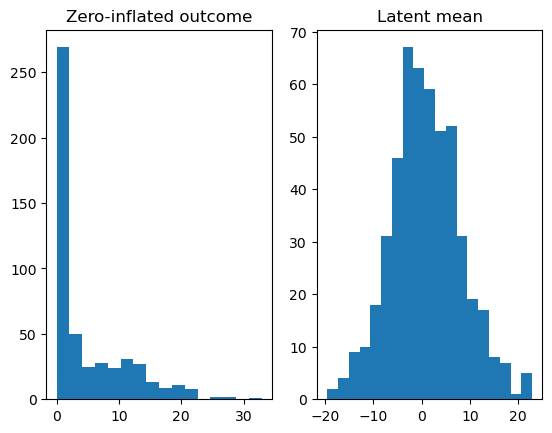

------------------------------------
genetic variance is 52.36226175791252
total variance is104.72452351582504
heritability is 0.5
------------------------------------


In [161]:
rho = 0.6
var = 1
n_matrix = 1
h = 0.5
beta_bias = 1
sim_class = data_sim.sim_tobit_data(n = n, p = p, p_causal = p_causal, rho = rho, var = var, n_matrix = n_matrix,h = h, bias = beta_bias, Xs = Xs, scale_lambda =None)
z, X, Xs, latent_mean, var_genetic, var_total, true_beta, y_star = sim_class.gen_data(seed = None)
data_sim.show_sim(z, latent_mean, var_total)

In [162]:
model = linear_slab_spike(p = p, init_pi_local = 0.2, init_pi_global = 0.1, init_beta_var = 2, init_noise_var = 0.1,
                         gumbel_softmax_temp = 1, gumbel_softmax_hard = True, 
                          a= 0.1, b=0.1, init_c= 0.1, init_d = 0.1,
                          q1 = 1.1, q2 = 1.1, init_q3 = 1.1, init_q4 = 1.1, n_E = 100, prior_sparsity = True
                         ).double()
optimizer = torch.optim.Adam(
    [{'params': model.beta_mu},
     {'params': model.beta_log_var},
     {'params': model.logit_pi_local, 'lr': 0.5},
     {'params': model.log_c},
     {'params': model.log_d},
     {'params': model.log_q3},
     {'params': model.log_q4},
     {'params': model.bias},
     {'params': model.logit_pi_global},
     {'params': model.beta_log_var_prior},
     {'params': model.log_var_noise},
    ],
    lr = 0.05)

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
t = 100 #number of moving averages
patience = 50# patience
p_cur = 0 
min_avg_loss = float('inf')
losses = []
for i in range(10000):
    loss = -model.ELBO(X.double(),y_star.double())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if i % 1000 == 0:
        lr_scheduler.step()
        print(f'At iteration {i}, the loss is {loss.item()}')
    if i > t:
        cur_avg_loss = np.mean(losses[-t:-1])
        if cur_avg_loss < min_avg_loss:
            min_avg_loss = cur_avg_loss
            p_cur = 0
            best_model = copy.deepcopy(model)
        else:
            p_cur += 1
    if p_cur > patience:
        break

At iteration 0, the loss is 93543.59148282545
At iteration 1000, the loss is 4153.620639382812
At iteration 2000, the loss is 3976.195757440779


In [ ]:
best_model.inference(X = X.double(),  num_samples = 1000, plot = True, true_beta = true_beta)

In [138]:
p_causal/p

0.01

In [23]:
torch.sum(torch.sigmoid(model.logit_pi_local)>0.9)/p

tensor(0.0008)

In [11]:
print(torch.max(torch.sigmoid(model.logit_pi_local)))
print(torch.min(torch.sigmoid(model.logit_pi_local)))

tensor(2.1269e-05, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(3.6996e-08, dtype=torch.float64, grad_fn=<MinBackward1>)


In [12]:
torch.min(model.beta_mu)

tensor(-0.0113, dtype=torch.float64, grad_fn=<MinBackward1>)

In [13]:
torch.max(model.beta_mu)

tensor(0.0110, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [14]:
torch.exp(model.beta_log_var)

tensor([0.7338, 0.7338, 0.7338,  ..., 0.7338, 0.7338, 0.7338],
       dtype=torch.float64, grad_fn=<ExpBackward0>)

In [15]:
torch.mean(torch.exp(model.beta_log_var))

tensor(0.7337, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [10]:
c = torch.exp(best_model.log_c).detach().numpy()
d = torch.exp(best_model.log_d).detach().numpy()
# c = 10
# d = 1000
print(c)
print(d)
posterior = np.random.beta(c,d,size = (5000,))
np.median(posterior)

[4.10831128]
[1813.69400553]


0.0021048419179539512

In [11]:
print(np.quantile(posterior, q = 0.025))
print(np.quantile(posterior, q = 0.975))

0.0006107508157321758
0.004793543542811561


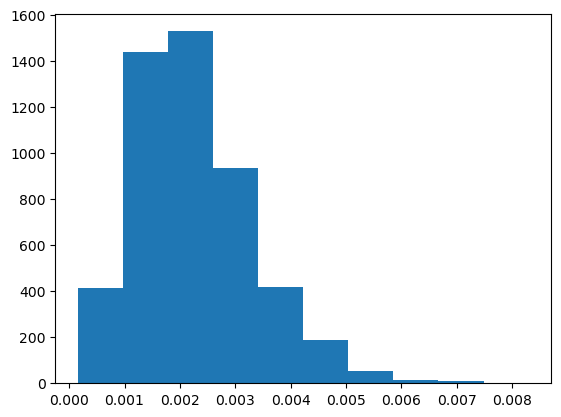

In [12]:
plt.hist(posterior)
plt.show()

# 